In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.9 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_mri"
DATASET = "masoudnickparvar/brain-tumor-mri-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Dataset downloaded to: brain_tumor_mri


In [4]:
from pathlib import Path

TRAIN_DIR = Path(DATA_DIR) / "Training"

class_map = {
    "glioma": 0,
    "meningioma": 1,
    "notumor": 2,
    "pituitary": 3
}

paths, labels = [], []

for class_name, class_id in class_map.items():
    class_dir = TRAIN_DIR / class_name
    for img_path in class_dir.glob("*"):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            paths.append(str(img_path))
            labels.append(class_id)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

num_classes = len(class_map)

print("Total images:", len(df))
print("Classes:", class_map)


Total images: 5600
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=0
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=0
)


In [9]:
model = timm.create_model(
    "convnextv2_base.fcmae_ft_in22k_in1k",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

summary(model, input_size=(1,3,224,224))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 4]                    --
├─Sequential: 1-1                                            [1, 128, 56, 56]          --
│    └─Conv2d: 2-1                                           [1, 128, 56, 56]          6,272
│    └─LayerNorm2d: 2-2                                      [1, 128, 56, 56]          256
├─Sequential: 1-2                                            [1, 1024, 7, 7]           --
│    └─ConvNeXtStage: 2-3                                    [1, 128, 56, 56]          --
│    │    └─Identity: 3-1                                    [1, 128, 56, 56]          --
│    │    └─Sequential: 3-2                                  [1, 128, 56, 56]          418,176
│    └─ConvNeXtStage: 2-4                                    [1, 256, 28, 28]          --
│    │    └─Sequential: 3-3                                  [1, 256, 28, 28]         

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [11]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [12]:
from PIL import Image


In [14]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "convnextv2_base.fcmae_ft_in22k_in1k")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 224/224 [03:48<00:00,  1.02s/it]



===== Epoch 1 TRAIN =====
Loss: 1.3935
Acc: 0.2531 | Prec: 0.2527 | Recall: 0.2531 | F1: 0.2525
Spec: 0.7510 | Sens: 0.2531 | MCC: 0.0041 | AUC: 0.4872


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.24it/s]



===== Epoch 1 VALID =====
Loss: 1.3895
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.5378
Current LR: 4.783864e-04



Training - Epoch [2/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 2 TRAIN =====
Loss: 1.3912
Acc: 0.2503 | Prec: 0.2482 | Recall: 0.2503 | F1: 0.2454
Spec: 0.7501 | Sens: 0.2503 | MCC: 0.0004 | AUC: 0.4990


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.28it/s]



===== Epoch 2 VALID =====
Loss: 1.3879
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.5534
Current LR: 4.665064e-04



Training - Epoch [3/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 3 TRAIN =====
Loss: 1.3890
Acc: 0.2570 | Prec: 0.2537 | Recall: 0.2570 | F1: 0.2506
Spec: 0.7523 | Sens: 0.2570 | MCC: 0.0094 | AUC: 0.5021


Validating: 100%|██████████| 56/56 [00:16<00:00,  3.29it/s]



===== Epoch 3 VALID =====
Loss: 1.3899
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.5623
Current LR: 4.522542e-04



Training - Epoch [4/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 4 TRAIN =====
Loss: 1.3922
Acc: 0.2469 | Prec: 0.2471 | Recall: 0.2469 | F1: 0.2448
Spec: 0.7490 | Sens: 0.2469 | MCC: -0.0041 | AUC: 0.4842


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.29it/s]



===== Epoch 4 VALID =====
Loss: 1.3871
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6006
Current LR: 4.357862e-04



Training - Epoch [5/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 5 TRAIN =====
Loss: 1.3896
Acc: 0.2430 | Prec: 0.2422 | Recall: 0.2430 | F1: 0.2420
Spec: 0.7477 | Sens: 0.2430 | MCC: -0.0093 | AUC: 0.4894


Validating: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]



===== Epoch 5 VALID =====
Loss: 1.3883
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6070
Current LR: 4.172827e-04



Training - Epoch [6/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 6 TRAIN =====
Loss: 1.3881
Acc: 0.2603 | Prec: 0.2576 | Recall: 0.2603 | F1: 0.2466
Spec: 0.7534 | Sens: 0.2603 | MCC: 0.0142 | AUC: 0.5000


Validating: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]



===== Epoch 6 VALID =====
Loss: 1.3887
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6600
Current LR: 3.969463e-04



Training - Epoch [7/30]: 100%|██████████| 224/224 [03:46<00:00,  1.01s/it]



===== Epoch 7 TRAIN =====
Loss: 1.3880
Acc: 0.2567 | Prec: 0.2578 | Recall: 0.2567 | F1: 0.2490
Spec: 0.7522 | Sens: 0.2567 | MCC: 0.0091 | AUC: 0.5028


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.26it/s]



===== Epoch 7 VALID =====
Loss: 1.3922
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6878
Current LR: 3.750000e-04



Training - Epoch [8/30]: 100%|██████████| 224/224 [03:46<00:00,  1.01s/it]



===== Epoch 8 TRAIN =====
Loss: 1.3912
Acc: 0.2561 | Prec: 0.2556 | Recall: 0.2561 | F1: 0.2523
Spec: 0.7520 | Sens: 0.2561 | MCC: 0.0083 | AUC: 0.5032


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.26it/s]



===== Epoch 8 VALID =====
Loss: 1.3869
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.4887
Current LR: 3.516842e-04



Training - Epoch [9/30]: 100%|██████████| 224/224 [03:46<00:00,  1.01s/it]



===== Epoch 9 TRAIN =====
Loss: 1.3421
Acc: 0.3030 | Prec: 0.3407 | Recall: 0.3030 | F1: 0.3056
Spec: 0.7677 | Sens: 0.3030 | MCC: 0.0725 | AUC: 0.5577


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.29it/s]



===== Epoch 9 VALID =====
Loss: 1.2939
Acc: 0.3304 | Prec: 0.4816 | Recall: 0.3304 | F1: 0.2288
Spec: 0.7768 | Sens: 0.3304 | MCC: 0.2233 | AUC: 0.6527
Current LR: 3.272542e-04



Training - Epoch [10/30]: 100%|██████████| 224/224 [03:46<00:00,  1.01s/it]



===== Epoch 10 TRAIN =====
Loss: 1.2658
Acc: 0.3485 | Prec: 0.4171 | Recall: 0.3485 | F1: 0.3601
Spec: 0.7828 | Sens: 0.3485 | MCC: 0.1344 | AUC: 0.6076


Validating: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]



===== Epoch 10 VALID =====
Loss: 1.2095
Acc: 0.4185 | Prec: 0.5047 | Recall: 0.4185 | F1: 0.3581
Spec: 0.8062 | Sens: 0.4185 | MCC: 0.2692 | AUC: 0.7261
Current LR: 3.019779e-04



Training - Epoch [11/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 11 TRAIN =====
Loss: 1.1459
Acc: 0.4542 | Prec: 0.4706 | Recall: 0.4542 | F1: 0.4456
Spec: 0.8181 | Sens: 0.4542 | MCC: 0.2796 | AUC: 0.7023


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.29it/s]



===== Epoch 11 VALID =====
Loss: 1.1577
Acc: 0.4263 | Prec: 0.3601 | Recall: 0.4263 | F1: 0.3394
Spec: 0.8088 | Sens: 0.4263 | MCC: 0.3043 | AUC: 0.7392
Current LR: 2.761321e-04



Training - Epoch [12/30]: 100%|██████████| 224/224 [03:47<00:00,  1.02s/it]



===== Epoch 12 TRAIN =====
Loss: 1.1083
Acc: 0.4835 | Prec: 0.4925 | Recall: 0.4835 | F1: 0.4673
Spec: 0.8278 | Sens: 0.4835 | MCC: 0.3248 | AUC: 0.7323


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.27it/s]



===== Epoch 12 VALID =====
Loss: 1.1655
Acc: 0.5290 | Prec: 0.5221 | Recall: 0.5290 | F1: 0.5092
Spec: 0.8430 | Sens: 0.5290 | MCC: 0.3802 | AUC: 0.7503
Current LR: 2.500000e-04



Training - Epoch [13/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 13 TRAIN =====
Loss: 1.3960
Acc: 0.2550 | Prec: 0.2558 | Recall: 0.2550 | F1: 0.2527
Spec: 0.7517 | Sens: 0.2550 | MCC: 0.0067 | AUC: 0.5102


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.28it/s]



===== Epoch 13 VALID =====
Loss: 1.3912
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.5476
Current LR: 2.238679e-04



Training - Epoch [14/30]: 100%|██████████| 224/224 [03:47<00:00,  1.02s/it]



===== Epoch 14 TRAIN =====
Loss: 1.3911
Acc: 0.2475 | Prec: 0.2506 | Recall: 0.2475 | F1: 0.2392
Spec: 0.7492 | Sens: 0.2475 | MCC: -0.0034 | AUC: 0.4918


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.25it/s]



===== Epoch 14 VALID =====
Loss: 1.3885
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.5812
Current LR: 1.980221e-04



Training - Epoch [15/30]: 100%|██████████| 224/224 [03:47<00:00,  1.01s/it]



===== Epoch 15 TRAIN =====
Loss: 1.3903
Acc: 0.2425 | Prec: 0.2420 | Recall: 0.2425 | F1: 0.2410
Spec: 0.7475 | Sens: 0.2425 | MCC: -0.0101 | AUC: 0.4863


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.28it/s]



===== Epoch 15 VALID =====
Loss: 1.3889
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6219
Current LR: 1.727458e-04



Training - Epoch [16/30]: 100%|██████████| 224/224 [03:46<00:00,  1.01s/it]



===== Epoch 16 TRAIN =====
Loss: 1.3873
Acc: 0.2489 | Prec: 0.2496 | Recall: 0.2489 | F1: 0.2455
Spec: 0.7496 | Sens: 0.2489 | MCC: -0.0015 | AUC: 0.5025


Validating: 100%|██████████| 56/56 [00:17<00:00,  3.29it/s]


===== Epoch 16 VALID =====
Loss: 1.3881
Acc: 0.2500 | Prec: 0.0625 | Recall: 0.2500 | F1: 0.1000
Spec: 0.7500 | Sens: 0.2500 | MCC: 0.0000 | AUC: 0.6539
Current LR: 1.483158e-04

Early stopping triggered.


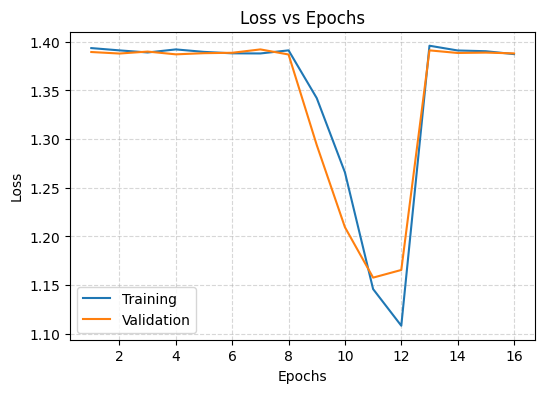

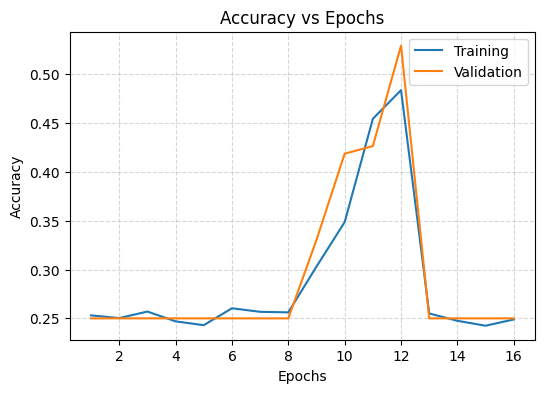

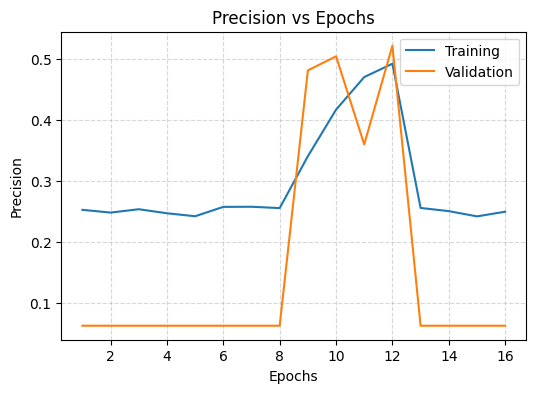

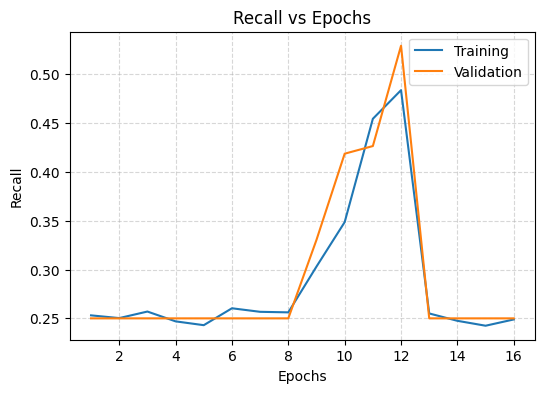

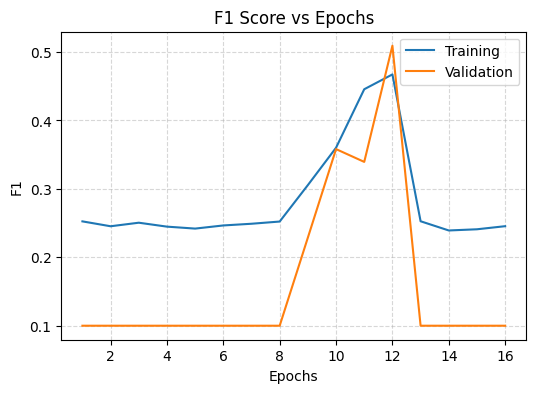

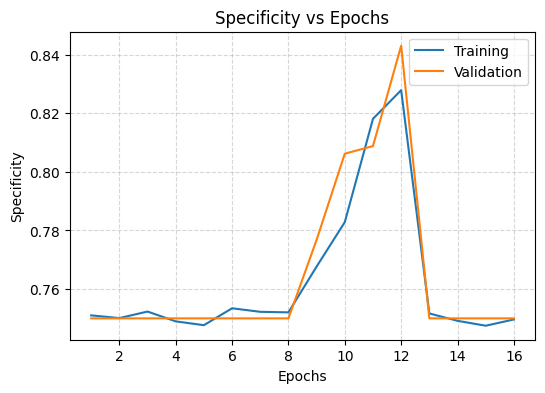

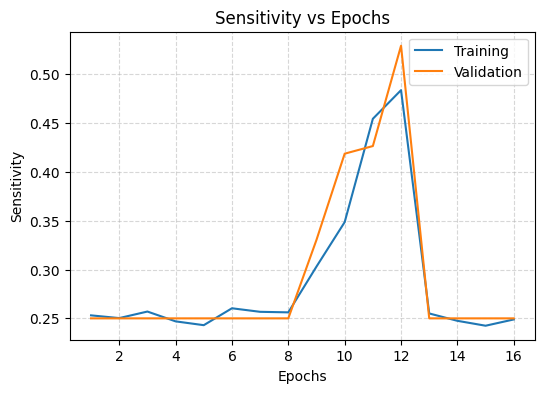

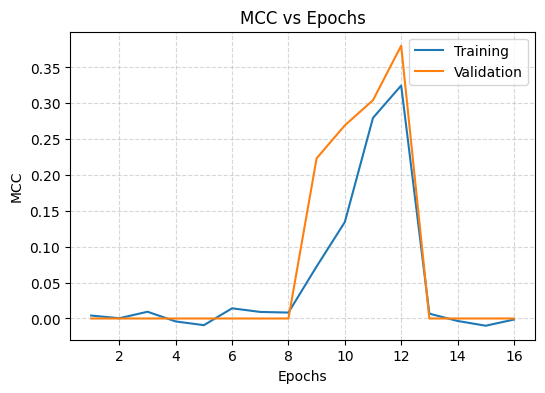

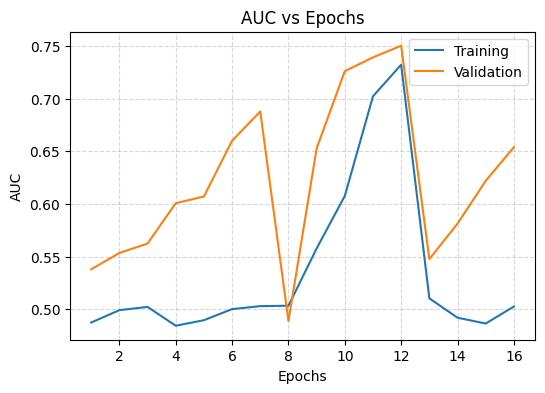

In [15]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [16]:
# Load best model
model.load_state_dict(torch.load("convnextv2_base.fcmae_ft_in22k_in1k"))

model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), strid

In [17]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 70/70 [00:21<00:00,  3.26it/s]


===== TEST RESULTS =====
Test Loss: 1.1546
ACC: 0.4321
PRECISION: 0.4303
RECALL: 0.4321
F1: 0.3502
AUC: 0.7335
MCC: 0.3141


In [18]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.3434    0.9750    0.5079       280
           1     0.4255    0.1429    0.2139       280
           2     0.7522    0.6071    0.6719       280
           3     0.2000    0.0036    0.0070       280

    accuracy                         0.4321      1120
   macro avg     0.4303    0.4321    0.3502      1120
weighted avg     0.4303    0.4321    0.3502      1120



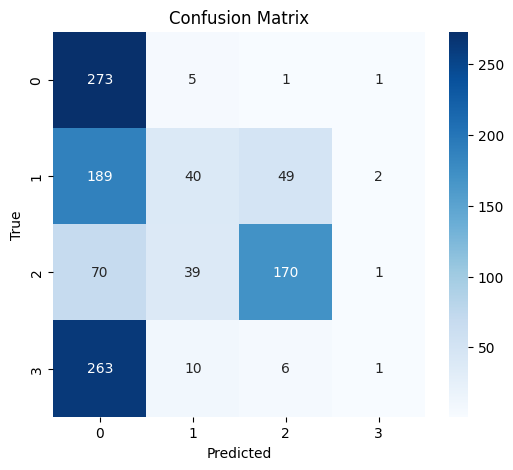

In [19]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


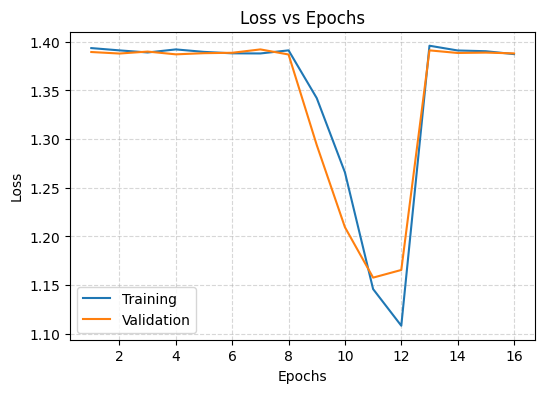

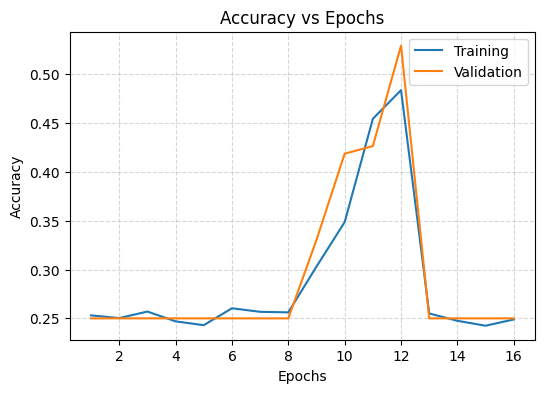

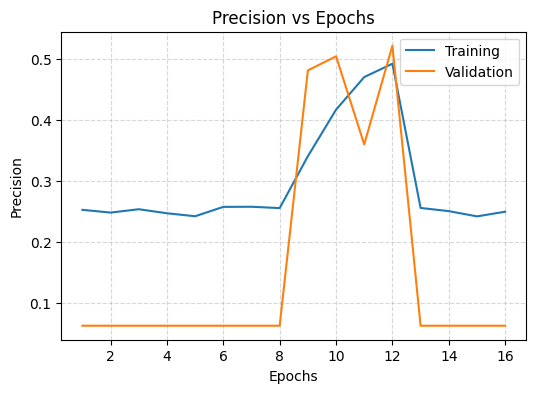

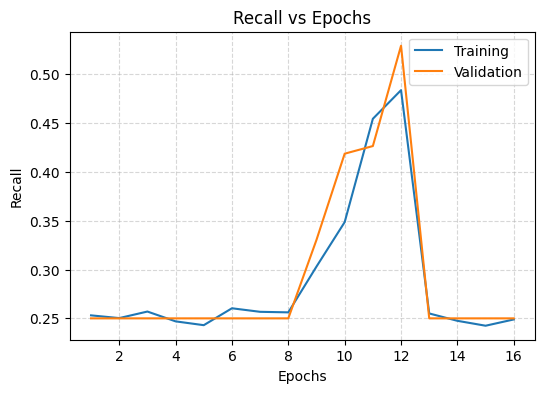

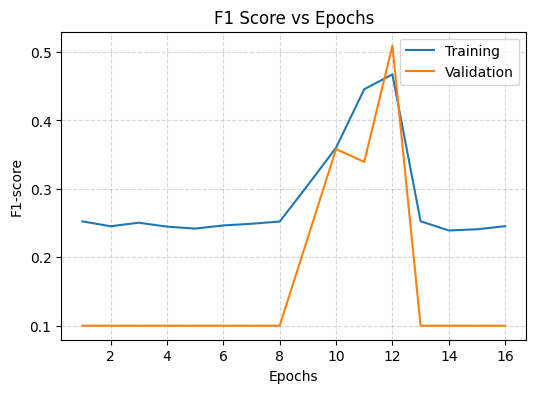

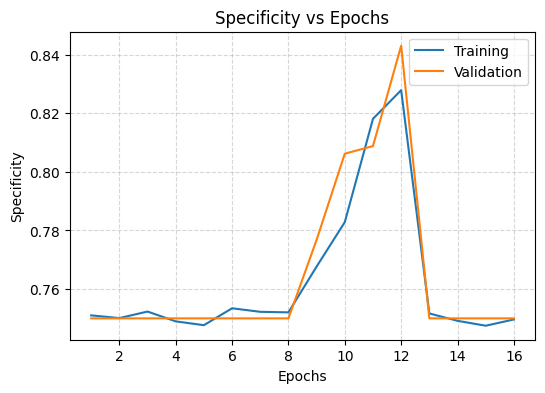

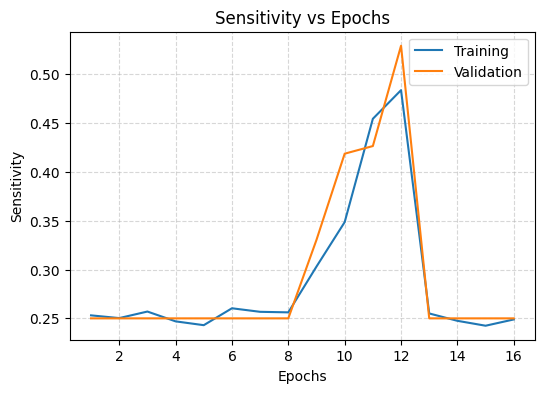

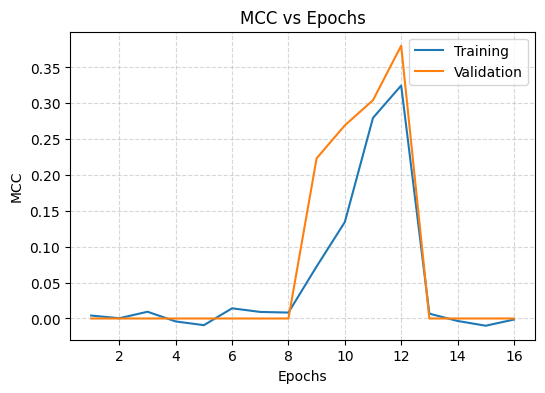

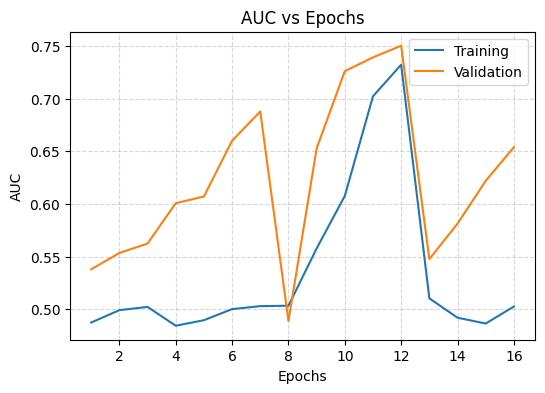

In [21]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
